In [1]:
!wget https://dysk.agh.edu.pl/s/G6ZNziBRbEEcMeN/download/Bike-Sharing-Dataset.zip -O Bike-Sharing-Dataset.zip
!unzip Bike-Sharing-Dataset.zip
!cat Readme.txt

--2024-05-27 18:21:04--  https://dysk.agh.edu.pl/s/G6ZNziBRbEEcMeN/download/Bike-Sharing-Dataset.zip
Resolving dysk.agh.edu.pl (dysk.agh.edu.pl)... 149.156.96.4, 2001:6d8:10:1060::6004
Connecting to dysk.agh.edu.pl (dysk.agh.edu.pl)|149.156.96.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase     [ <=>                ] 273.43K  --.-KB/s    in 0.05s   

2024-05-27 18:21:04 (5.27 MB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                
Bike Sharing Dataset

Hadi Fanaee-T

Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto
INESC Porto, Campus da FEUP
Rua Dr. Roberto Frias, 378
4200 - 465 Porto, Portugal


Background 

Bike sharing systems are new generation of traditional bike rentals where whole pr

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.appName("BikerRental").master("local[*]").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/27 18:21:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv('day.csv', header=True, inferSchema=True)
df.show(5)
df.printSchema()

+-------+----------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----+
|instant|    dteday|season| yr|mnth|holiday|weekday|workingday|weathersit|    temp|   atemp|     hum|windspeed|casual|registered| cnt|
+-------+----------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----+
|      1|2011-01-01|     1|  0|   1|      0|      6|         0|         2|0.344167|0.363625|0.805833| 0.160446|   331|       654| 985|
|      2|2011-01-02|     1|  0|   1|      0|      0|         0|         2|0.363478|0.353739|0.696087| 0.248539|   131|       670| 801|
|      3|2011-01-03|     1|  0|   1|      0|      1|         1|         1|0.196364|0.189405|0.437273| 0.248309|   120|      1229|1349|
|      4|2011-01-04|     1|  0|   1|      0|      2|         1|         1|     0.2|0.212122|0.590435| 0.160296|   108|      1454|1562|
|      5|2011-01-05|     1|  0|   1|      0|      3|   

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
pdf =df.toPandas()

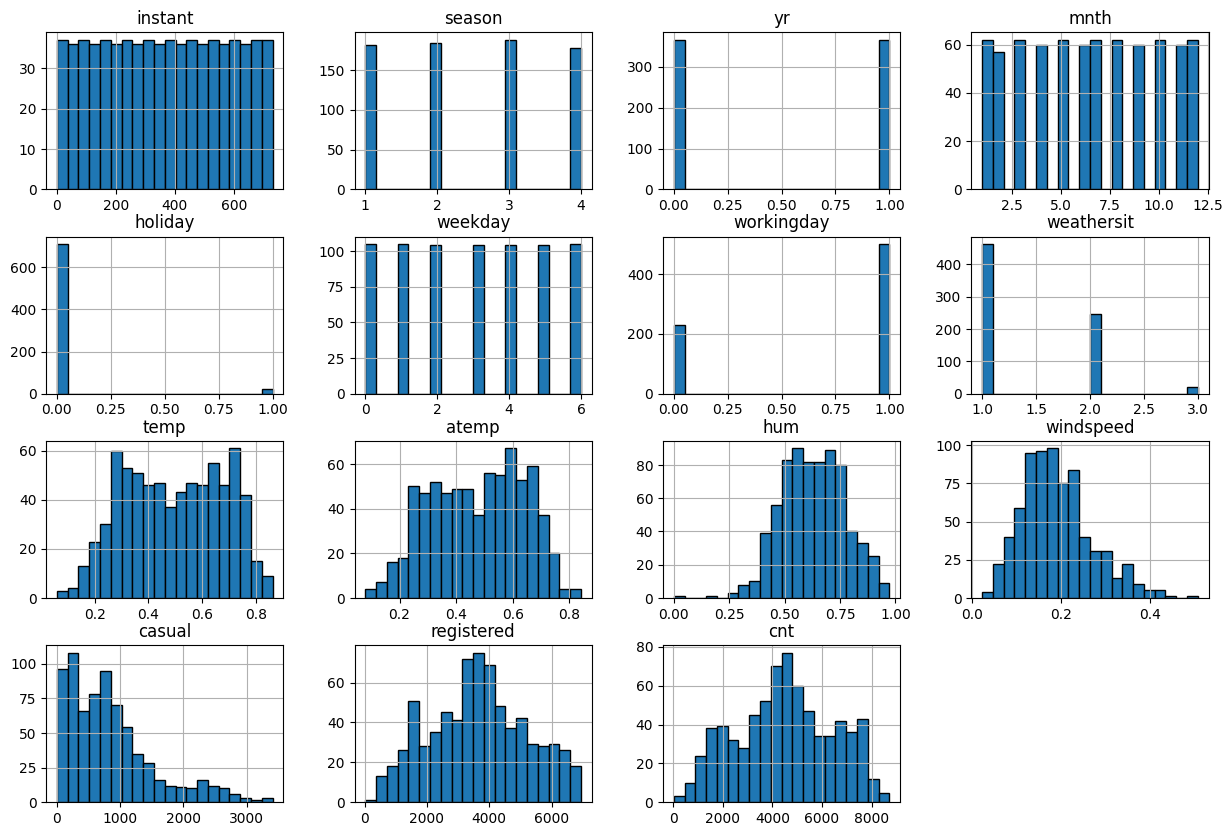

In [6]:
pdf.hist(bins=20, edgecolor='black')
plt.show()

In [9]:
dates = df.select('dteday').rdd.flatMap(lambda x:x).collect()


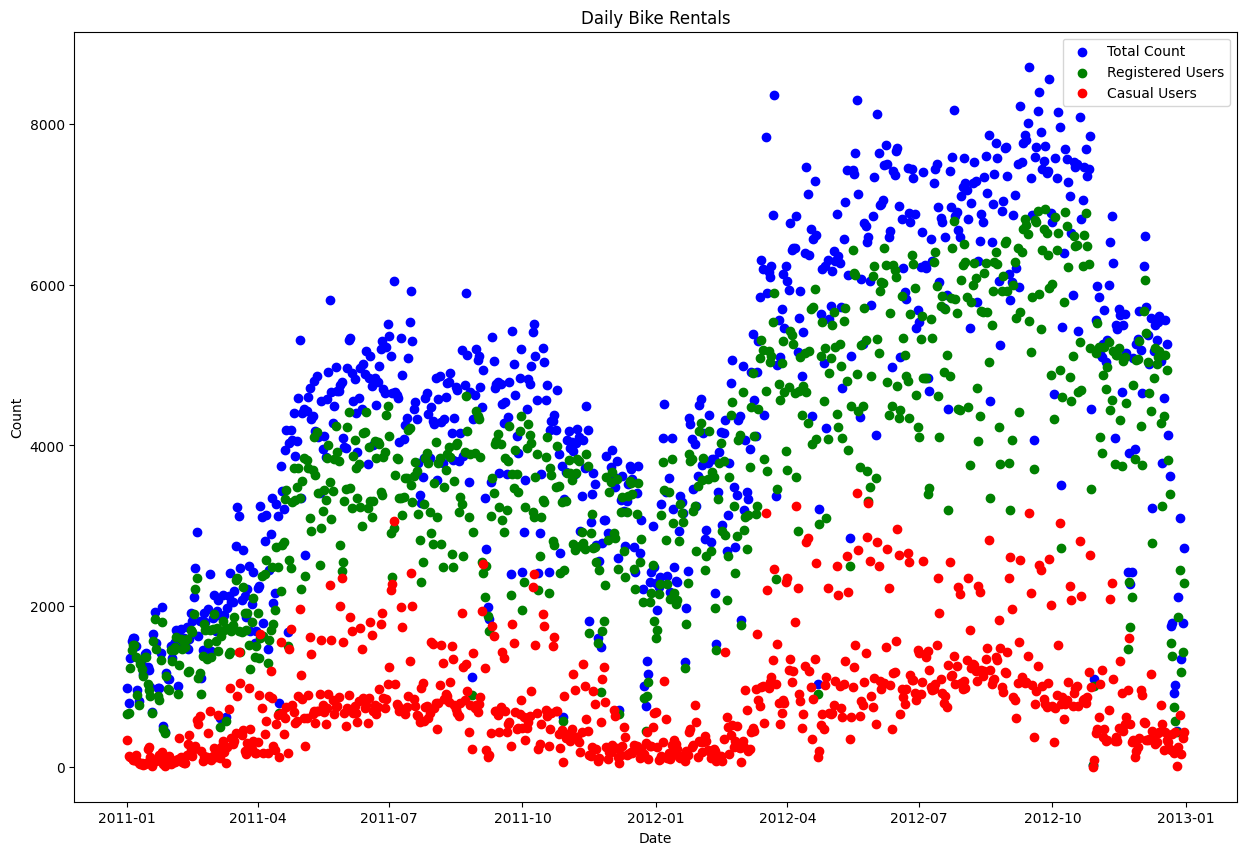

In [17]:
plt.figure(figsize=(15, 10))
plt.scatter(dates, pdf['cnt'], label='Total Count', color='blue')
plt.scatter(dates, pdf['registered'], label='Registered Users', color='green')
plt.scatter(dates, pdf['casual'], label='Casual Users', color='red')


plt.title('Daily Bike Rentals')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()

In [54]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
 
def evaluate_metrics(df,metrics=['r2','rmse','mse','mae'],label_col='cnt',prediction_col='prediction'):

    """
    Funkcja oblicza metryki regresji na podstawie zbioru danych zawierającego prawdziwe wartosci etykiet 
    i wartości przewidywane
    :param df: Dataset<Row> wejściowy zbiór danych
    :param metrics: lista metryk do obliczenia
    :param label_col: nazwa kolumny z wartościami wyjściowymi
    :param prediction_col: nazwa kolumny zawierającej przewidywane wartości
    :return: słownik zawierający pary (nazwa_metryki, wartość) 
    """
    
    metrics_result = {}
    for metric in metrics:
        evaluator = RegressionEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName=metric)
        value = evaluator.evaluate(df)
        metrics_result[metric] = value

    return metrics_result

In [95]:
def train_and_test(df,lr=LinearRegression(maxIter=100,regParam=3.0,elasticNetParam=0.5,labelCol ='cnt',featuresCol  = 'features' )):
    """
    Funkcja (1) dzieli zbiór danych na ``df_train`` oraz ``df_test`` 
    (2) tworzy ciąg przetwarzania zawierający ``VectorAssembler`` 
    i  przekazaną jako parametr konfiguracje algorytmu regresji
    (3) buduje model i dokonuje predykcji dla ``df_train`` oraz ``df_test``
    (4) wyświetla metryki
    :param df: wejściowy zbiór danych
    :param lr: konfiguracja algorytmu regresji
    :return: model  zwrócony przez ``pipeline.fit()``
    """

    df_train, df_test = df.randomSplit([0.8, 0.3], seed=42)
    feature_cols = df.columns
    feature_cols.remove('cnt')
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(df_train)

    pred_train = model.transform(df_train)
    pred_test = model.transform(df_test)

    metric = evaluate_metrics(pred_train, label_col='cnt', prediction_col='prediction')
    metric2 = evaluate_metrics(pred_test, label_col='cnt', prediction_col='prediction')

    print("train" ,metric)
    print("test", metric2)
    
    return model

In [149]:
df2 = df.withColumn("unixdate", unix_timestamp("dteday"))
df2 = df2.drop("dteday","registered","casual","instant")

df2.show(5)

+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+----+----------+
|season| yr|mnth|holiday|weekday|workingday|weathersit|    temp|   atemp|     hum|windspeed| cnt|  unixdate|
+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+----+----------+
|     1|  0|   1|      0|      6|         0|         2|0.344167|0.363625|0.805833| 0.160446| 985|1293840000|
|     1|  0|   1|      0|      0|         0|         2|0.363478|0.353739|0.696087| 0.248539| 801|1293926400|
|     1|  0|   1|      0|      1|         1|         1|0.196364|0.189405|0.437273| 0.248309|1349|1294012800|
|     1|  0|   1|      0|      2|         1|         1|     0.2|0.212122|0.590435| 0.160296|1562|1294099200|
|     1|  0|   1|      0|      3|         1|         1|0.226957| 0.22927|0.436957|   0.1869|1600|1294185600|
+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+----+----------+
only showing top 5 

In [97]:
model = train_and_test(df2)

train {'r2': 0.7972620581431438, 'rmse': 859.1719348533287, 'mse': 738176.4136396125, 'mae': 645.5278101564094}
test {'r2': 0.8045379258845459, 'rmse': 889.7241851088936, 'mse': 791609.1255676848, 'mae': 637.2162005410484}


In [100]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

def train_and_test2(df,lr=LinearRegression(maxIter=100,regParam=3.0,elasticNetParam=0.5,labelCol ='cnt',featuresCol  = "features" )):
    
    df_train, df_test = df.randomSplit([0.8, 0.2], seed=42)
    
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.1, 0.5, 1, 2, 3, 5, 10]) \
        .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
        .build()

    feature_cols = df.columns
    feature_cols.remove('cnt')
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    pipeline = Pipeline(stages=[assembler, lr])
    
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="cnt",predictionCol='prediction', metricName="r2"),
                          numFolds=5)

    cvModel = crossval.fit(df_train)
    bestModel = cvModel.bestModel
    print("Best model parameters:")
    print("regParam:", bestModel.stages[-1].getRegParam())
    print("elasticNetParam:", bestModel.stages[-1].getElasticNetParam())
    return bestModel

In [104]:
bestModel = train_and_test2(df2)

Exception ignored in: <function JavaWrapper.__del__ at 0x7f8a56a75990>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'LinearRegression' object has no attribute '_java_obj'


Best model parameters:
regParam: 3.0
elasticNetParam: 0.75


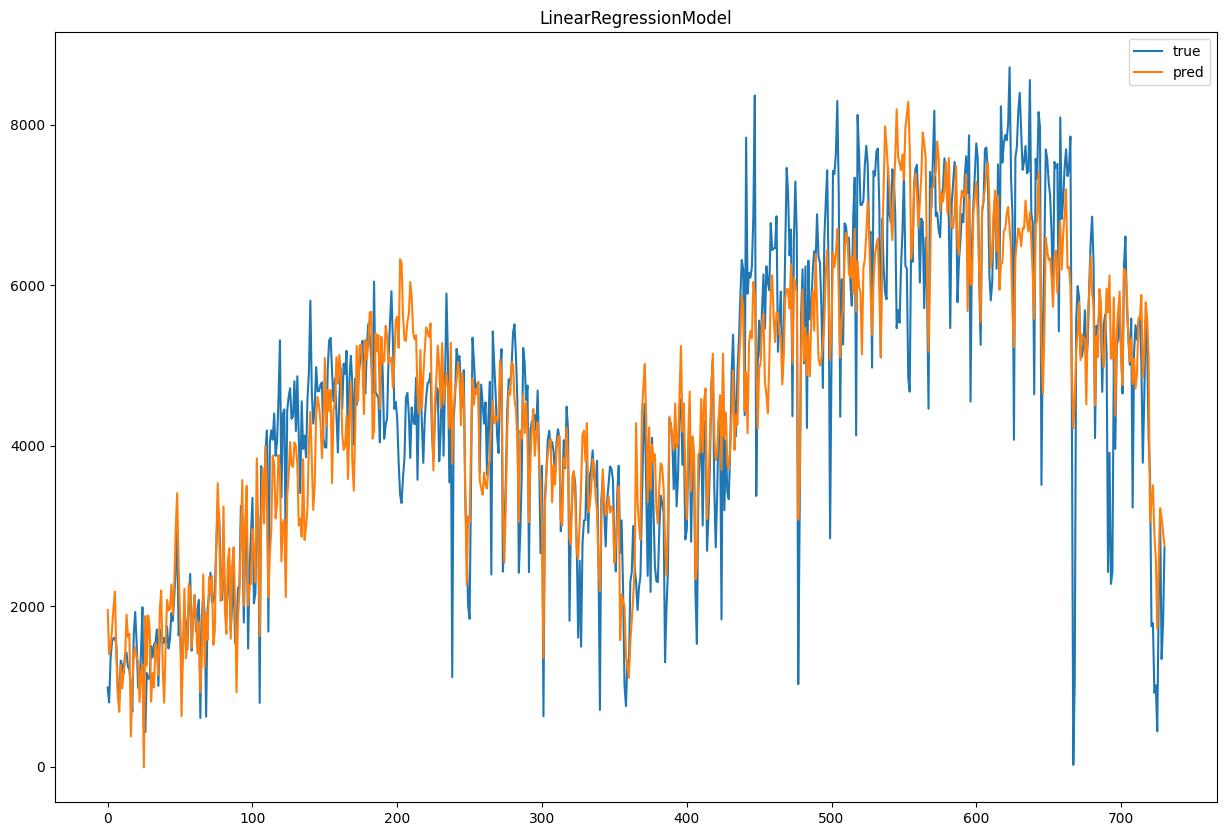

In [105]:
import numpy as np
 
def plot(df,model,start=0,end=-1):
    if end == -1:
        end = df.count()
    x = np.arange(start,end)
    y = df.select('cnt').rdd.flatMap(lambda x:x).collect()
    df_pred = model.transform(df)
    y_pred = df_pred.select('prediction').rdd.flatMap(lambda x:x).collect()  
    plt.plot(x,y[start:end],label='true')
    plt.plot(x,y_pred[start:end],label='pred')
    plt.legend()
    plt.title(model.stages[-1].__class__.__name__)
    plt.show()
 
plot(df2,bestModel)

In [107]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor


df_train, df_test = df2.randomSplit([0.8, 0.2], seed=42)

feature_cols = df2.columns
feature_cols.remove('cnt')
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
evaluator = RegressionEvaluator(labelCol="cnt", predictionCol="prediction", metricName="accuracy")

regression_models = [
    LinearRegression(maxIter=100, regParam=0.1, elasticNetParam=0.8, labelCol="cnt", featuresCol="features"),
    DecisionTreeRegressor(maxDepth=10,minInstancesPerNode=5,labelCol="cnt", featuresCol="features"),
    RandomForestRegressor(numTrees=100,maxDepth=10,subsamplingRate=0.8,labelCol="cnt", featuresCol="features"),
    GBTRegressor(maxIter=100,maxDepth=5,stepSize=0.1,labelCol="cnt", featuresCol="features")
]
for r in regression_models:
    
    pipeline = Pipeline(stages=[assembler, r])
    model = pipeline.fit(df_train)

    pred_train = model.transform(df_train)
    pred_test = model.transform(df_test)

    metric = evaluate_metrics(pred_train, label_col='cnt', prediction_col='prediction')
    metric2 = evaluate_metrics(pred_test, label_col='cnt', prediction_col='prediction')
    print(f'=== {r.__class__.__name__} ===')
    print("train", metric)
    print("test", metric2)

=== LinearRegression ===
train {'r2': 0.7966462495405052, 'rmse': 861.2019644288289, 'mse': 741668.8235360739, 'mae': 642.4319614304088}
test {'r2': 0.8183819601912752, 'rmse': 880.5102642541872, 'mse': 775298.3254569785, 'mae': 651.1044288932511}
=== DecisionTreeRegressor ===
train {'r2': 0.9295889125702076, 'rmse': 506.75663580653753, 'mse': 256802.2879339597, 'mae': 349.9201129213363}
test {'r2': 0.8010315345660572, 'rmse': 921.6097404792482, 'mse': 849364.5137462273, 'mae': 603.1198209394181}


24/05/27 19:31:30 WARN DAGScheduler: Broadcasting large task binary with size 1583.8 KiB
24/05/27 19:31:30 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/27 19:31:30 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/27 19:31:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


=== RandomForestRegressor ===
train {'r2': 0.9711272737874262, 'rmse': 324.5060625380474, 'mse': 105304.18462394713, 'mae': 231.37472404503444}
test {'r2': 0.8907932578803465, 'rmse': 682.7782161391433, 'mse': 466186.09243415075, 'mae': 461.59755018688986}
=== GBTRegressor ===
train {'r2': 0.9979649139266278, 'rmse': 86.15298110192697, 'mse': 7422.336152748984, 'mae': 63.05044239240411}
test {'r2': 0.8606814254579944, 'rmse': 771.1865420091005, 'mse': 594728.6825759542, 'mae': 481.8811014001447}


In [109]:
import matplotlib.pyplot as plt


model_rf = train_and_test(df2, RandomForestRegressor(numTrees=100,maxDepth=10,subsamplingRate=0.8,labelCol="cnt", featuresCol="features"))


24/05/27 19:36:34 WARN DAGScheduler: Broadcasting large task binary with size 1546.5 KiB
24/05/27 19:36:34 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/27 19:36:35 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/05/27 19:36:35 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


train {'r2': 0.9681975247284381, 'rmse': 340.28517380854333, 'mse': 115793.99951391054, 'mae': 239.16469715114084}
test {'r2': 0.8882244136492934, 'rmse': 672.818032942618, 'mse': 452684.1054527738, 'mae': 463.12861219880034}


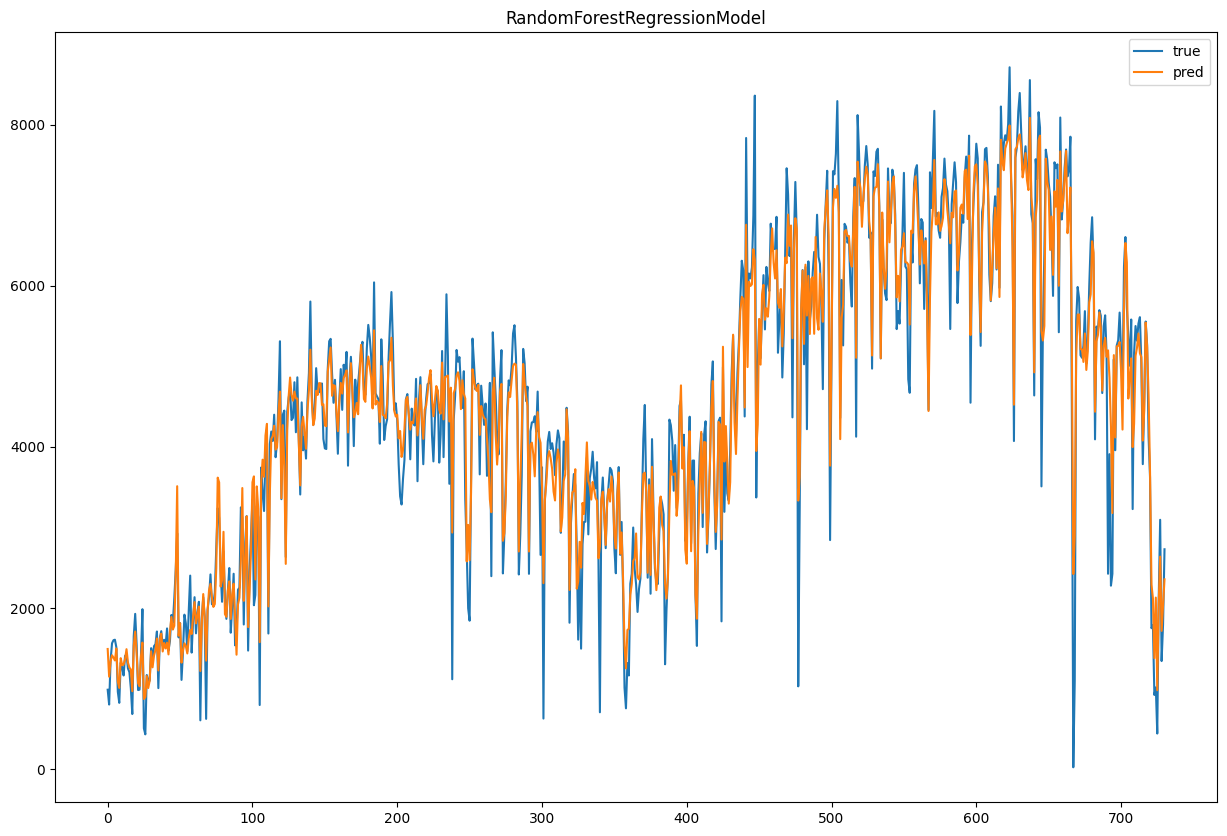

In [110]:
plot(df2,model_rf)

In [128]:
feature_cols = df2.columns
feature_cols.remove('cnt')

results = []
for col_name in feature_cols:
    correlation = df2.stat.corr(col_name, 'cnt')
    results.append((col_name, correlation))
    
for col_name, correlation in results:
    print(f"Korelacja między {col_name} a cnt: {correlation}")

Korelacja między season a cnt: 0.40610037079863526
Korelacja między yr a cnt: 0.5667097078680867
Korelacja między mnth a cnt: 0.27997711221927024
Korelacja między holiday a cnt: -0.068347715892484
Korelacja między weekday a cnt: 0.06744341241063077
Korelacja między workingday a cnt: 0.06115606306052114
Korelacja między weathersit a cnt: -0.2973912388346634
Korelacja między temp a cnt: 0.6274940090334914
Korelacja między atemp a cnt: 0.6310656998491828
Korelacja między hum a cnt: -0.1006585621371548
Korelacja między windspeed a cnt: -0.23454499742167056
Korelacja między unixdate a cnt: 0.6288302722083062


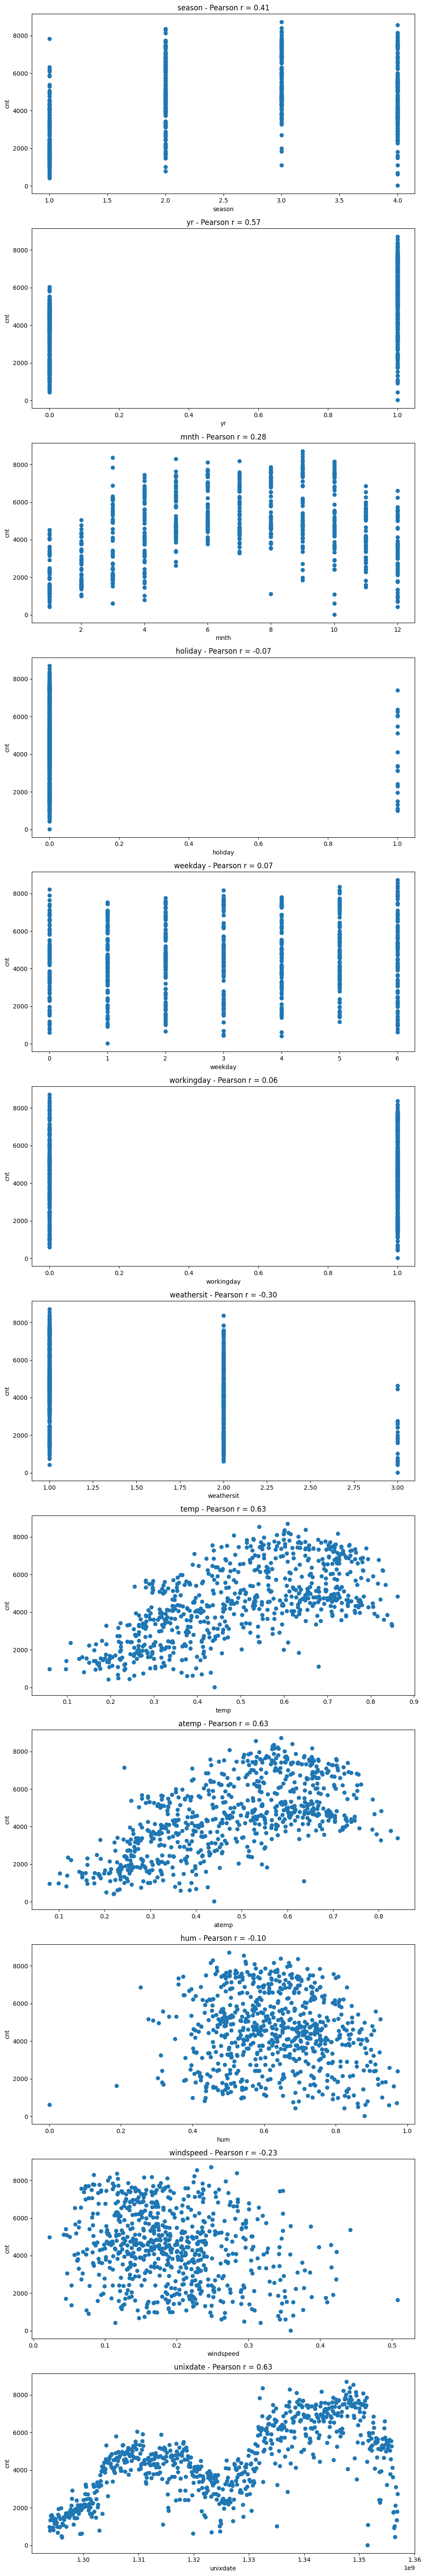

In [131]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=len(feature_cols), ncols=1, figsize=(10, 5 * len(feature_cols)))

for i, (col_name, correlation) in enumerate(results):

    temp_pd = df2.select(col_name, 'cnt').toPandas()
    ax = axes[i] if len(selected_cols) > 1 else axes
    ax.scatter(temp_pd[col_name], temp_pd['cnt'])
    ax.set_xlabel(col_name)
    ax.set_ylabel('cnt')
    ax.set_title(f"{col_name} - Pearson r = {correlation:.2f}")

plt.tight_layout()
plt.show()

In [132]:
from pyspark.ml.feature import OneHotEncoder
 
encoder = OneHotEncoder(inputCol="weekday", outputCol="categoryVec")
model = encoder.fit(df2)
df_encoded = model.transform(df2)
df_encoded.show()

+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+----+----------+-------------+
|season| yr|mnth|holiday|weekday|workingday|weathersit|    temp|   atemp|     hum|windspeed| cnt|  unixdate|  categoryVec|
+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+----+----------+-------------+
|     1|  0|   1|      0|      6|         0|         2|0.344167|0.363625|0.805833| 0.160446| 985|1293840000|    (6,[],[])|
|     1|  0|   1|      0|      0|         0|         2|0.363478|0.353739|0.696087| 0.248539| 801|1293926400|(6,[0],[1.0])|
|     1|  0|   1|      0|      1|         1|         1|0.196364|0.189405|0.437273| 0.248309|1349|1294012800|(6,[1],[1.0])|
|     1|  0|   1|      0|      2|         1|         1|     0.2|0.212122|0.590435| 0.160296|1562|1294099200|(6,[2],[1.0])|
|     1|  0|   1|      0|      3|         1|         1|0.226957| 0.22927|0.436957|   0.1869|1600|1294185600|(6,[3],[1.0])|
|     1|  0|   1

In [157]:
from pyspark.ml.feature import OneHotEncoder

def encode_one_hot(df, col):
    """
    Funkcja przekształca wybraną kolumnę do postaci one-hot - tablicy wartości 0/1

    :param df: Dataset<Row> wejściowy zbiór danych
    :param col: kolumna do konwersji one-hot
    :return: zbiór danych z kolumną col przekształconą do postaci one-hot 

    Używa OneHotEncoder z biblioteki pyspark.ml.feature do konwersji kolumny 
    kategorialnej do postaci one-hot. Zwraca zakodowany zbiór danych.
    """

    encoder = OneHotEncoder(inputCols=[col], outputCols=[col+ "categoryVec"])
    encoded_df = encoder.fit(df).transform(df)

    return encoded_df

In [164]:
df3 = encode_one_hot(df2,'mnth')
df3 = df3.drop('mnth')
df3 = encode_one_hot(df3,'weekday')
df3 = df3.drop('weekday')
df3 = encode_one_hot(df3,'season')
df3 = df3.drop('season')
df3 = encode_one_hot(df3,'weathersit')
df3 = df3.drop('weathersit')
df3.show()

+---+-------+----------+--------+--------+--------+---------+----+----------+---------------+------------------+-----------------+---------------------+
| yr|holiday|workingday|    temp|   atemp|     hum|windspeed| cnt|  unixdate|mnthcategoryVec|weekdaycategoryVec|seasoncategoryVec|weathersitcategoryVec|
+---+-------+----------+--------+--------+--------+---------+----+----------+---------------+------------------+-----------------+---------------------+
|  0|      0|         0|0.344167|0.363625|0.805833| 0.160446| 985|1293840000| (12,[1],[1.0])|         (6,[],[])|    (4,[1],[1.0])|        (3,[2],[1.0])|
|  0|      0|         0|0.363478|0.353739|0.696087| 0.248539| 801|1293926400| (12,[1],[1.0])|     (6,[0],[1.0])|    (4,[1],[1.0])|        (3,[2],[1.0])|
|  0|      0|         1|0.196364|0.189405|0.437273| 0.248309|1349|1294012800| (12,[1],[1.0])|     (6,[1],[1.0])|    (4,[1],[1.0])|        (3,[1],[1.0])|
|  0|      0|         1|     0.2|0.212122|0.590435| 0.160296|1562|1294099200| (12,

In [160]:
from sklearn.preprocessing import PolynomialFeatures


24/05/27 20:44:28 WARN DAGScheduler: Broadcasting large task binary with size 1097.5 KiB
24/05/27 20:44:29 WARN DAGScheduler: Broadcasting large task binary with size 1774.3 KiB
24/05/27 20:44:29 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/27 20:44:30 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/05/27 20:44:30 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


train {'r2': 0.9648693531991274, 'rmse': 359.99541811557924, 'mse': 129596.70106421073, 'mae': 256.8712365379541}
test {'r2': 0.9109664576139589, 'rmse': 591.8064913136516, 'mse': 350234.92316097516, 'mae': 436.692540593819}


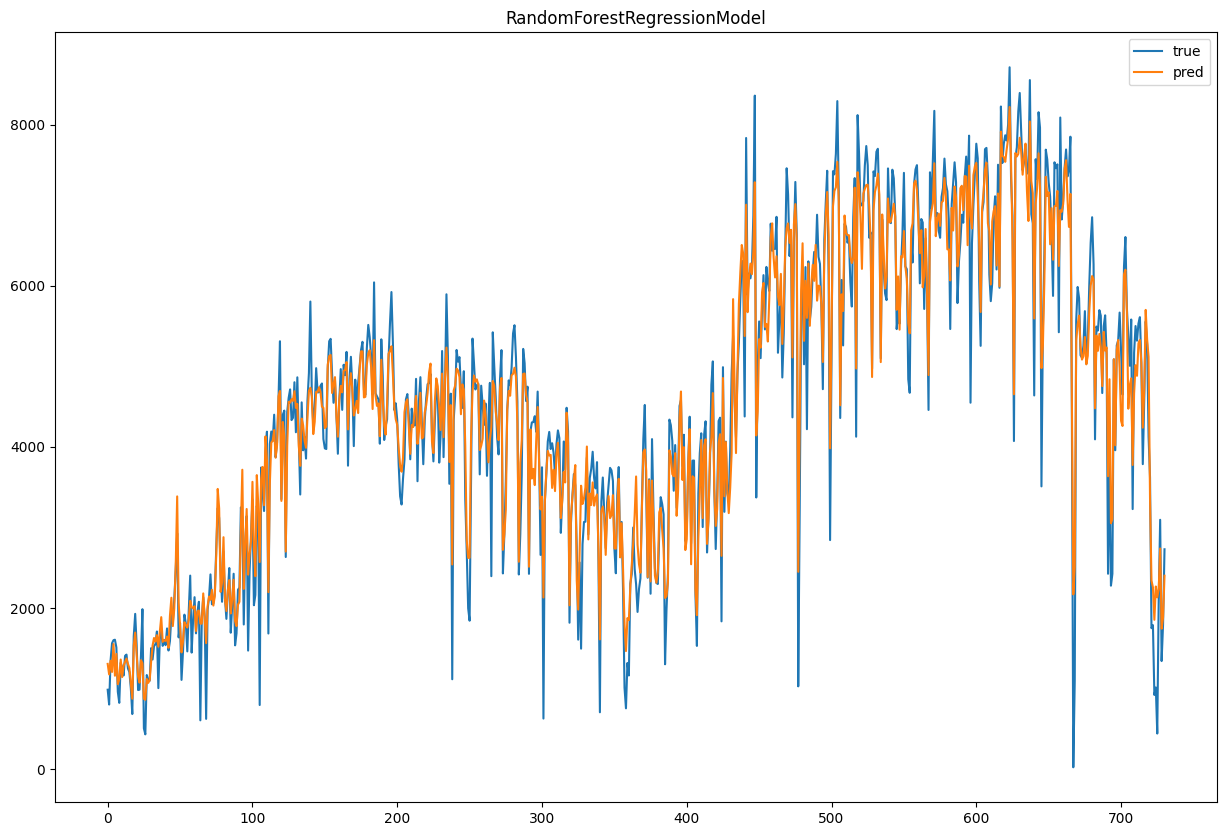

In [193]:
model = train_and_test(df3, RandomForestRegressor(numTrees=100,maxDepth=10,subsamplingRate=0.8,labelCol="cnt", featuresCol="features"))
plot(df3,model)

In [321]:
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion
from pyspark.ml.regression import LinearRegression
 
# Param for the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.
 
def train_polynomial_features(df,lr=LinearRegression(),degree=2):
    """
    Funkcja przetwarza cały zbiór danych 
    (1) tworzy ciag przetwarzania zawierający ``VectorAssembler`` 
    z jedynym wejściowym atrybutem ``instance``, dalej ''PolynomialExpansion'' 
    i  przekazaną jako parametr konfiguracje algorytmu regresji
    (2) buduje model i dokonuje predykcji dla ``df``
    (3) wyświetla metryki za pomocą funkcji ``evaluate_metrics()``
    :param df: wejściowy zbiór danych
    :param lr: konfiguracja algorytmu regresji wielomianu (argument ``PolynomialExpansion``)
    :param degree: stopień wielomianu (argument PolynomialExpansion)
    :return: model  zwrócony przez ``pipeline.fit()``
    """


 
    assembler = VectorAssembler(inputCols=["instant"], outputCol="features")
    polynomial_expansion = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=degree)
    pipeline = Pipeline(stages=[assembler,polynomial_expansion,lr])

    model = pipeline.fit(df)
    pred_train = model.transform(df)


    metric = evaluate_metrics(pred_train, label_col='cnt', prediction_col='prediction')
    print(metric)


    return model



{'r2': 0.6832482509416997, 'rmse': 1089.5302185708297, 'mse': 1187076.097179, 'mae': 835.2080648138077}
[55.58474793394235,-0.21784482843784084,0.00013497822930951979,5.963761814280408e-07,-6.952862499204957e-10]
Iterations:  8578


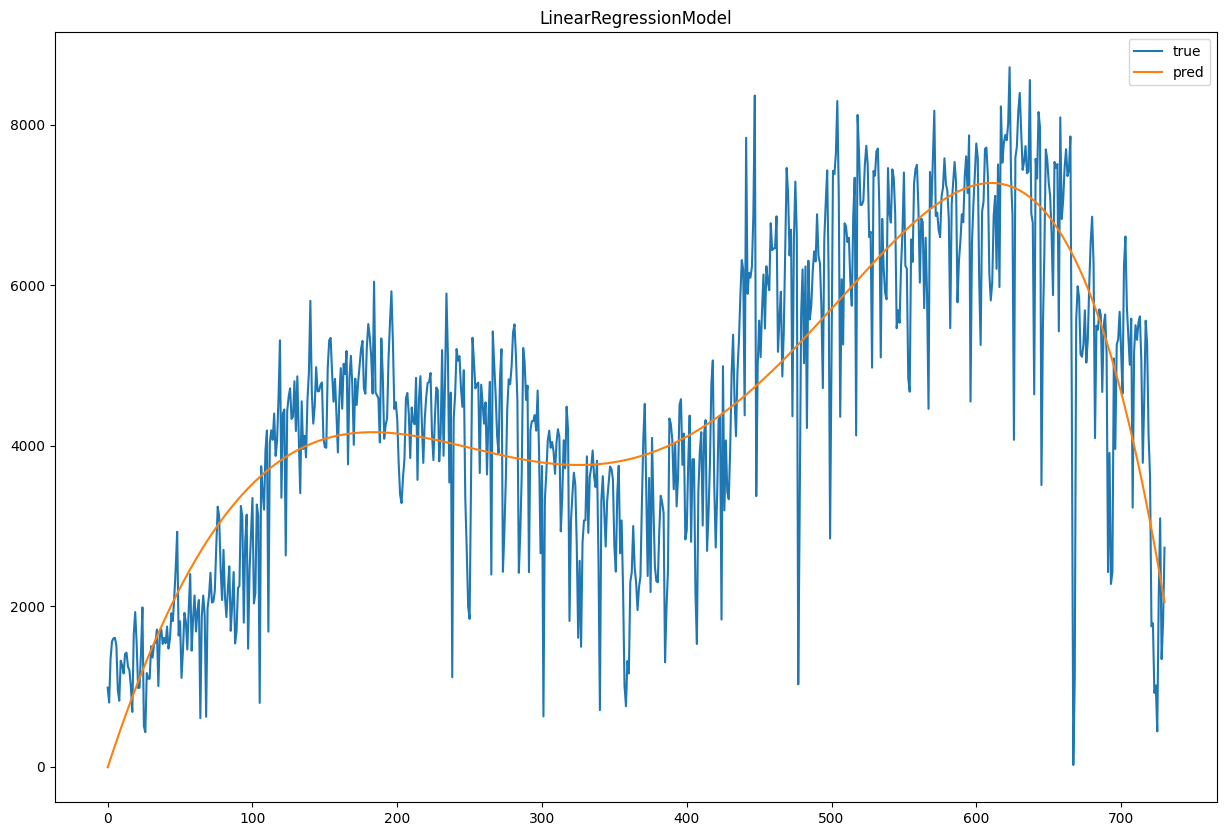

In [322]:
model = train_polynomial_features(df, lr = LinearRegression(maxIter=1000000 ,regParam=0.01,elasticNetParam=0.9, labelCol="cnt", featuresCol="poly_features"),degree=5)
print(model.stages[-1].coefficients)
print('Iterations: ',model.stages[-1].summary.totalIterations)
plot(df,model)


In [323]:
!pip install seaborn
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 916.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 2.0 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 KB 2.8 MB/s eta 0:00:00a 0:00:01


<Axes: >

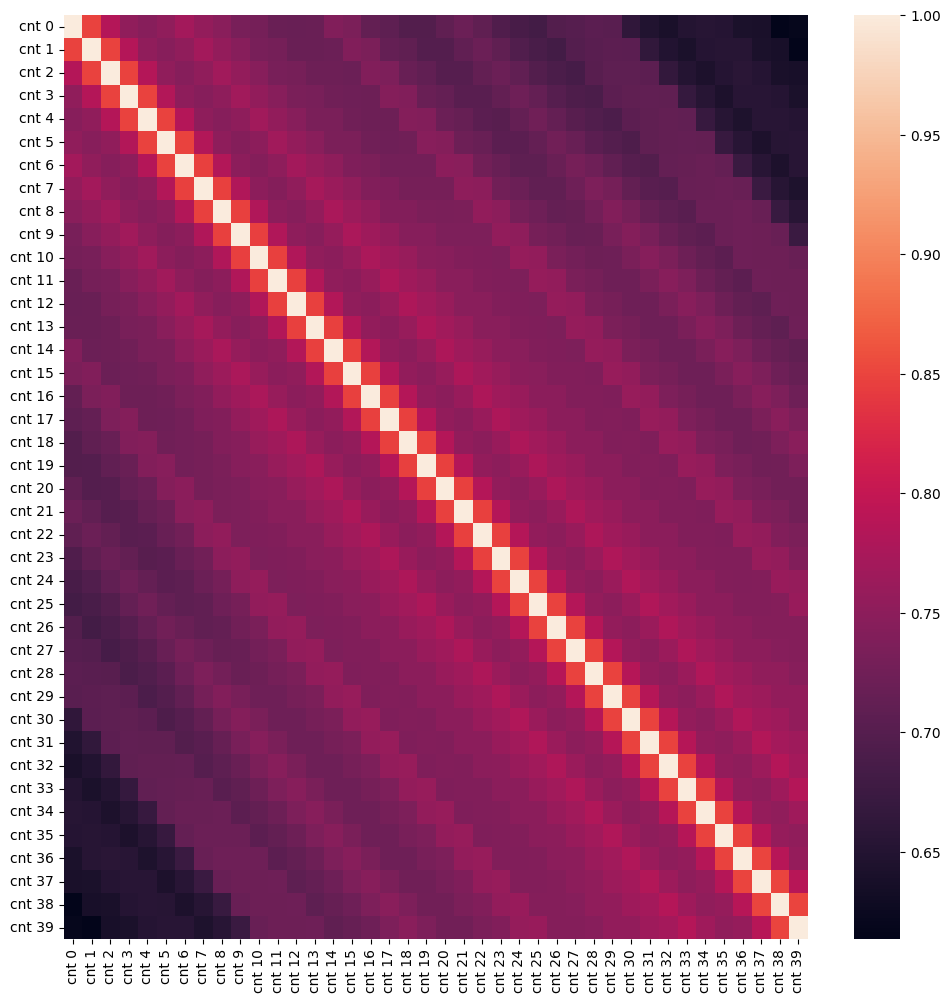

In [324]:
import pandas as pd
pdf = df.toPandas()
shifted = [pd.DataFrame(data = pdf.cnt).shift(i) for i in range(40)]
for i in range(len(shifted)):
  shifted[i].columns=['cnt '+str(i)]
# print(shifted)
df_shifted = pd.concat(shifted,axis=1)
# df_shifted.head(20)
 
corr_mat = df_shifted.corr()
import seaborn as sn
plt.rcParams['figure.figsize'] = (12, 12)
sn.heatmap(corr_mat,xticklabels=df_shifted.columns,yticklabels=df_shifted.columns)

Exception ignored in: <function JavaWrapper.__del__ at 0x7f8a56a75990>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'LinearRegression' object has no attribute '_java_obj'


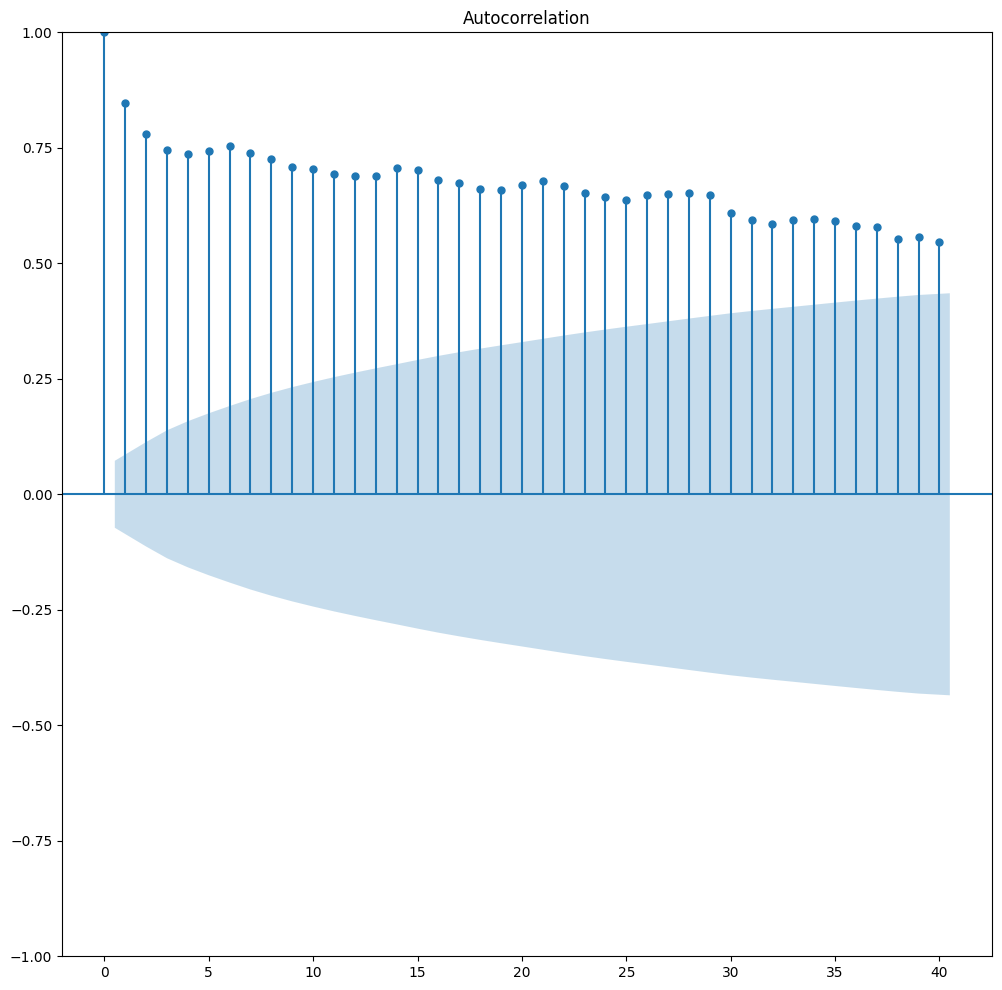

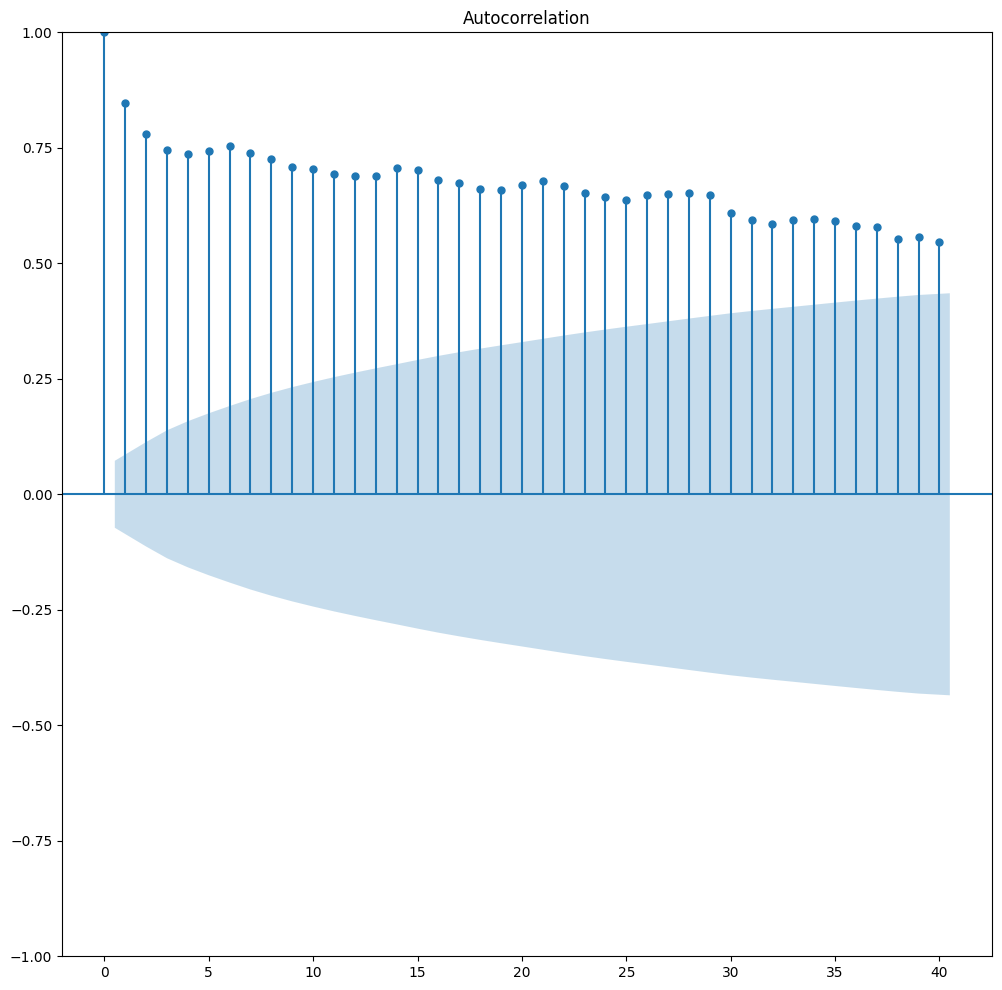

In [325]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(pdf.cnt,lags=40)

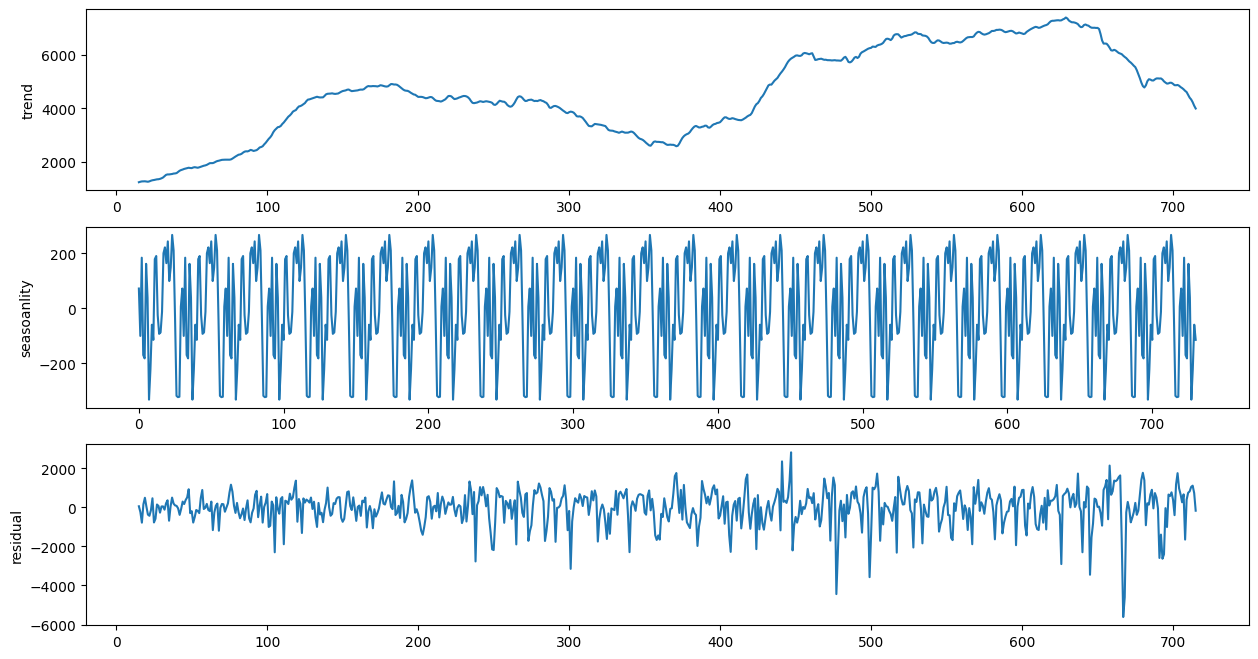

In [326]:
from statsmodels.tsa.seasonal import seasonal_decompose
 
res = seasonal_decompose(pdf.cnt, model = "additive",period=30)
 
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.seasonal.plot(ax=ax2,ylabel = "seasoanlity")
res.resid.plot(ax=ax3,ylabel = "residual")
plt.show()

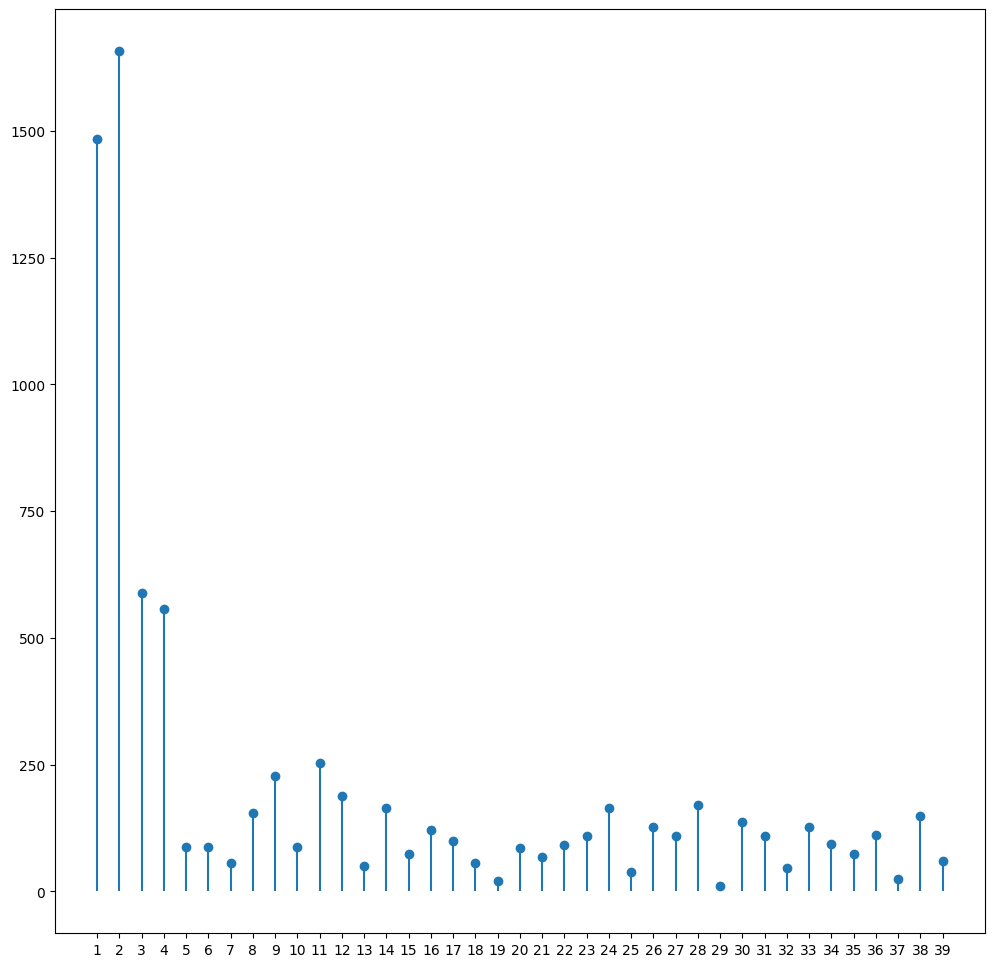

In [327]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
 
y = pdf.cnt.to_numpy()
x = np.arange(-y.shape[0]//2,y.shape[0]//2)
 
yf = scipy.fftpack.fft(y)
 
N=y.shape[0]
 
yf = scipy.fftpack.fft(y)
yf[0]=0
xf = np.arange(1,40)
 
plt.scatter(xf, 2.0/N * np.abs(yf[1:40]))
plt.vlines(xf, np.zeros(39),2.0/N * np.abs(yf[1:40]))
plt.xticks(xf)
plt.show()